In [1]:
import sys
import os
script_dir = os.getcwd()
root_dir = os.path.join(os.path.dirname(os.path.abspath(script_dir)))
sys.path.append(os.path.join(os.path.dirname(os.path.abspath(script_dir))))
os.chdir(root_dir)

In [6]:
os.getcwd()

'/home/helenajun/rag-llm-cancer-paper'

In [2]:
from utils.io import save_object, load_object
import pandas as pd
from sklearn.model_selection import train_test_split
import json
_VERSION="v1"

In [3]:
real_world_db_entity_mapped=pd.read_csv(f"data/real_world_db/real_world_db_entity_mapped_cancerAnnot__{_VERSION}.csv", index_col=0)
real_world_db_entity_mapped.head()

,prompt,cancer_category,cancer_type,biomarker
0,what is the first-line treatment of metastatic...,GU,"['urothelial carcinoma', 'metastatic']",['fgfr3']
1,are parp inhibitors used for patients with lei...,Sarcoma,['leiomyosarcoma'],"['dna', 'parp']"
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,['rhabdomyosarcoma'],"['alk', 'tfcp2']"
3,for a patient with cancer metastatic prostate ...,GU,"['prostate cancer', 'cancer']",['brca2']
4,for a patient with her2+ breast cancer after n...,Breast,"['breast cancer', 'disease']",['her2']


In [12]:
val, test = train_test_split(
    real_world_db_entity_mapped,
    test_size=0.88,
    stratify=real_world_db_entity_mapped['cancer_category'],
    random_state=42
)

In [14]:
val.shape

(12, 4)

In [15]:
real_world_db_entity_mapped['dataset'] = None
real_world_db_entity_mapped.loc[val.index, 'dataset'] = 'validation'
real_world_db_entity_mapped.loc[test.index, 'dataset'] = 'test'
real_world_db_entity_mapped.dataset.value_counts()

dataset
test          90
validation    12
Name: count, dtype: int64

In [16]:
for split_name, split_df in zip(['Validation','Test'], [val,test]):
    print(split_name)
    print(split_df['cancer_category'].value_counts(normalize=True))
    print()

Validation
cancer_category
GI             0.250000
GU             0.250000
CNS            0.083333
Hematologic    0.083333
Endocrine      0.083333
Sarcoma        0.083333
Lung           0.083333
Breast         0.083333
Name: proportion, dtype: float64

Test
cancer_category
GU             0.211111
GI             0.200000
Hematologic    0.122222
Breast         0.100000
CNS            0.088889
Sarcoma        0.066667
Lung           0.066667
Endocrine      0.044444
Unspecified    0.033333
Other          0.022222
Skin           0.022222
GYN            0.022222
Name: proportion, dtype: float64



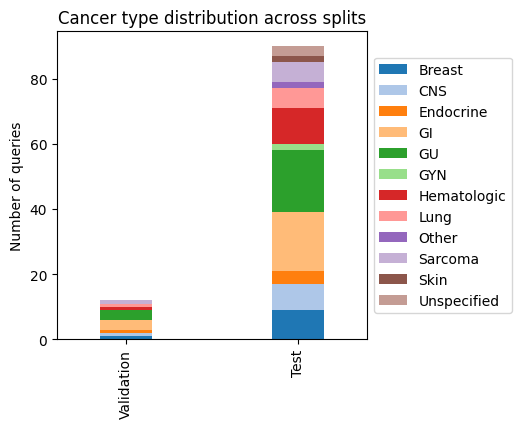

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

categories=real_world_db_entity_mapped['cancer_category'].unique()
palette = sns.color_palette("tab20", n_colors=len(categories))  # qualitative, up to 20 colors

counts = pd.DataFrame({
    'Validation': val['cancer_category'].value_counts(),
    'Test': test['cancer_category'].value_counts()
}).fillna(0)

counts.T.plot(kind='bar', stacked=True, color=palette, figsize=(4,4), width=0.3)
plt.ylabel("Number of queries")
plt.title("Cancer type distribution across splits")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [19]:
real_world_db_entity_mapped.to_csv(f"data/real_world_db/real_world_db_split__{_VERSION}.csv")
real_world_db_entity_mapped.head()

,prompt,cancer_category,cancer_type,biomarker,dataset
0,what is the first-line treatment of metastatic...,GU,"['urothelial carcinoma', 'metastatic']",['fgfr3'],test
1,are parp inhibitors used for patients with lei...,Sarcoma,['leiomyosarcoma'],"['dna', 'parp']",test
2,are alk inhibitors approved for use in tfcp2 f...,Sarcoma,['rhabdomyosarcoma'],"['alk', 'tfcp2']",validation
3,for a patient with cancer metastatic prostate ...,GU,"['prostate cancer', 'cancer']",['brca2'],test
4,for a patient with her2+ breast cancer after n...,Breast,"['breast cancer', 'disease']",['her2'],test


In [27]:
with open(f"data/real_world_db/real_world_validation_query__{_VERSION}.json", "w") as f:
    json.dump(val['prompt'].tolist(), f)

with open(f"data/real_world_db/real_world_test_query__{_VERSION}.json", "w") as f:
    json.dump(test['prompt'].tolist(), f)

Create ground-truth answers

In [34]:
real_world_db=pd.read_csv(f"data/real_world_db/updated_real_world_queries_answers__{_VERSION}.csv", index_col=0)
real_world_db=real_world_db.dropna(subset='Questions').reset_index(drop=True)
real_world_db

,Questions,Expert_curated_ground-truth answers,Authors,All_onlabel_groundtruth_therapies_cleaned__v1,GenomicBiomarker_linked_onlabel_groundtruth_therapies__v1,Offlabel_groundtruth_therapies__v1,Note,Multiple_biomarkers,Asking_therapy,Asking_genomic_biomarker_linked_therapy
0,What is the first-line treatment of metastatic...,erdafitinib,Brendan,erdafitinib,erdafitinib,NaN,NaN,False,True,True
1,Are PARP inhibitors used for patients with lei...,PARP inhibitors are not yet approved for the t...,Brendan,NaN,NaN,NaN,NaN,False,True,True
2,Are ALK inhibitors approved for use in TFCP2 f...,"No, no ALK inhibitors are currently approved f...",Brendan,NaN,NaN,NaN,NaN,False,True,True
3,For a patient with cancer metastatic prostate ...,The following therapy and combination therapie...,Brendan,niraparib + prednisolone + abiraterone acetate...,niraparib + prednisolone + abiraterone acetate...,NaN,NaN,False,True,True
4,For a patient with HER2+ breast cancer after n...,TDM-1 (ado-trastuzumab emtansine (Kadcyla)),Brendan,trastuzumab emtansine,trastuzumab emtansine,NaN,NaN,False,True,True
...,...,...,...,...,...,...,...,...,...,...
97,What is an acceptable treatment in patients wi...,Elacestrant,Chris Labaki,elacestrant,elacestrant,NaN,NaN,True,True,True
98,What is an acceptable regimen in patients with...,"Pembrolizumab with trastuzumab, fluoropyrimidi...",Chris Labaki,trastuzumab + fluorouracil + cisplatin + pembr...,trastuzumab + fluorouracil + cisplatin + pembr...,NaN,NaN,True,True,True
99,Are there any genomically guided therapies tha...,"olaparib, enzalutamide + talazoparib, predniso...",Helena,"olaparib, enzalutamide + talazoparib, predniso...","olaparib, enzalutamide + talazoparib, predniso...",NaN,NaN,False,True,True
100,Which drugs are currently approved for the tre...,nirogacestat,Helena,nirogacestat,NaN,NaN,NaN,False,True,False


In [35]:
real_world_db_entity_mapped['All_onlabel_groundtruth_therapies_cleaned__v2'] = None

def parse_therapies(entry):
    if isinstance(entry, str):
        parts = entry.split(',')
        if len(parts) > 1:
            return [set(d.strip().split(' + ')) for d in parts]
        else:
            return [set(parts)]
    else:
        return []
    
real_world_db_entity_mapped['All_onlabel_groundtruth_therapies_cleaned__v2']=real_world_db['All_onlabel_groundtruth_therapies_cleaned__v1'].apply(parse_therapies)

In [36]:
real_world_db_entity_mapped.to_csv(f"data/real_world_db/real_world_db__{_VERSION}.csv")

In [38]:
real_world_query_therapy_pair_dict= dict(zip(real_world_db_entity_mapped['prompt'], real_world_db_entity_mapped['All_onlabel_groundtruth_therapies_cleaned__v2']))

In [39]:
real_world_query_therapy_pair_dict

{'what is the first-line treatment of metastatic urothelial carcinoma with fgfr3 s249c mutation?': [{'erdafitinib'}],
 'are parp inhibitors used for patients with leiomyosarcoma who have mutations in dna damage repair genes?': [],
 'are alk inhibitors approved for use in tfcp2 fusion positive rhabdomyosarcoma?': [],
 'for a patient with cancer metastatic prostate cancer, advanced stage (most often stage iv, but some stage iii or earlier potentially) and with brca2 mutation, what drugs approved?': [{'abiraterone acetate',
   'niraparib',
   'prednisolone'},
  {'abiraterone acetate', 'olaparib', 'prednisolone'},
  {'enzalutamide', 'talazoparib'},
  {'olaparib'},
  {'rucaparib'}],
 'for a patient with her2+ breast cancer after neoadjvuant chemotherapy + trastuzumab then surgery, if residual disease at time of surgery, what treatment options are approved afterwards?': [{'trastuzumab emtansine'}],
 'for patients with advanced cancer and with ntrk fusions, regardless of cancer types, are the

In [ ]:
save_object(real_world_query_therapy_pair_dict, f"data/real_world_db/real_world_query_therapy_pair_dict.pkl")